# Оценка вероятности осадков на завтра

Цель: построить модель прогноза осадков на завтра, основываясь на данных о погоде в Австралии.

Данные содержат 23 признака и 145 460 наблюдений. Из этих 23 признаков шесть — категориальные, в одном записана дата, а остальные являются непрерывными числовыми данными.

Примеры числовых признаков: температура, скорость ветра, влажность, облачность, атмосферное давление в разное время суток, количество осадков, испарение, количество часов с солнечной погодой.

Примеры категориальных признаков: местоположение, направление ветра в разное время суток, наличие дождя сегодня или завтра.
Целевой переменной является столбец RainTomorrow. Значение этой переменной мы и будем пытаться предсказать.

Подробная расшифровка всех признаков

- Date — дата, в которую зафиксировано наблюдение;
- Location — местонахождение метеорологической станции;
- MinTemp — минимальная температура (℃);
- MaxTemp — максимальная температура (℃);
- Rainfall — количество осадков (дождь) за сутки (мм);
- Evaporation — количество испарений до 9 утра (мм);
- Sunshine — количество часов в сутках, когда светило солнце;
- WindGustDir — направление самого сильного порыва ветра за последние 24 часа;
- WindGustSpeed — скорость самого сильного порыва ветра за последние 24 часа;
- WindDir9am — направление ветра в 9 утра;
- WindDir3pm — направление ветра в 3 часа дня;
- WindSpeed9am — скорость ветра в 9 часов утра;
- WindSpeed3pm — скорость ветра в 3 часа дня;
- Humidity9am — влажность в 9 утра;
- Humidity3pm — влажность в 3 часа дня;
- Pressure9am — атмосферное давление в 9 утра;
- Pressure3pm — атмосферное давление в 3 часа дня;
- Cloud9am — часть неба, закрытая облаками, в 9 утра;
- Cloud3pm — часть неба, закрытая облаками, в 3 часа дня;
- Temp9am — температура в 9 утра;
- Temp3pm — температура в 3 часа дня;
- RainToday — наличие дождя в этот день;
- RainTomorrow — наличие дождя на следующий день.


In [1]:
# Импорт нужных библиотек и модулей
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import roc_auc_score

In [2]:
# Посмотрим на данные
weather = pd.read_csv('weatherAUS.csv')
weather.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
# Общая информация о данных
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Некоторые признаки в данных имеют очень много пропусков: Evaporation, Sunshine, Cloud3pm, Cloud9am.

In [4]:
# Сколько всего пропусков в данных?
weather.isnull().sum().sum()

343248

In [5]:
# Удалим признаки, в которых более 40% пропусков
cols = list(weather.columns)
length = weather.shape[0]
for col in cols:
    if (weather[col].isna().sum()/length) > 0.4:
        weather.drop(col, axis=1, inplace=True)
        
weather.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,17.8,29.7,No,No


In [6]:
# Удалилось три признака
weather.shape

(145460, 20)

In [7]:
# Обработаем признаки RainToday и RainTomorrow таким образом, чтобы вместо Yes было значение 1, а вместо No — значение 0.

weather['RainToday'] = weather['RainToday'].apply(lambda x: {'Yes':1, 'No':0}.get(x,' '))
weather['RainTomorrow'] = weather['RainTomorrow'].apply(lambda x: {'Yes':1, 'No':0}.get(x,' '))

### Эти варианты не подходят, так как присваивают 0 всем встречающимся NaN:
#weather['RainToday'] = np.where(weather['RainToday'] == 'Yes', 1, 0)
#weather['RainTomorrow'] = np.where(weather['RainTomorrow'] == 'Yes', 1, 0)

weather[['RainToday', 'RainTomorrow']].sample(5)

,RainToday,RainTomorrow
102032,1,1
83472,,0
90442,1,1
51232,0,0
108716,1,1


In [8]:
# Переведём столбцы RainToday и RainTomorrow в числовой формат
def to_int(x):
    try:
        return int(x)
    except:
        return np.nan

weather['RainToday'] = weather['RainToday'].apply(to_int)
weather['RainTomorrow'] = weather['RainTomorrow'].apply(to_int)

# Оценим среднее значение по столбцу
weather['RainToday'].mean()

0.22419285648984874

In [9]:
# Обработаем признак Date таким образом, чтобы выделить в отдельный признак Month (номер месяца). 
# Изначальный признак Date удалим. 

weather['Date'] = pd.to_datetime(weather['Date'])
weather['Month'] = weather['Date'].dt.month
weather.drop('Date', axis=1, inplace=True)
weather.head()


,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Temp9am,Temp3pm,RainToday,RainTomorrow,Month
0,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,16.9,21.8,0.0,0.0,12
1,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,17.2,24.3,0.0,0.0,12
2,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,21.0,23.2,0.0,0.0,12
3,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,18.1,26.5,0.0,0.0,12
4,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,17.8,29.7,0.0,0.0,12


In [10]:
# В какой месяц выпадает больше всего дождей? (Ищем месяц с самой большой долей дождливых дней)

weather.groupby('Month')['RainToday'].mean().sort_values(ascending=False)

Month
7     0.270736
6     0.263638
8     0.253167
9     0.229135
5     0.222163
3     0.217135
4     0.216845
12    0.213037
11    0.210843
2     0.206746
10    0.196512
1     0.189484
Name: RainToday, dtype: float64

In [11]:
#Преобразуем признак месяца в строковый тип, чтобы в дальнейшем закодировать в dummy-переменные
weather['Month'] = weather['Month'].astype(str)

In [12]:
# Обработаем категориальные признаки. С помощью метода get_dummies с настройками по умолчанию 
# создадим dummy-переменные для всех категориальных признаков (всего их пять).
# Сколько получится признаков в данных, если считать целевую переменную?

weather = pd.get_dummies(weather)
weather.shape


(145460, 124)

In [13]:
# Удалим все строки с пропусками в данных
weather.dropna(inplace=True)
weather.reset_index(drop=True, inplace=True)
weather.shape

(78257, 124)

In [14]:
# Выполним разбиение данных на тренировочные и тестовые
X = weather.drop('RainTomorrow', axis=1)
y = weather['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31)

# Оценим среднее значение целевой переменной на тестовой выборке?
y_test.mean()

0.22770253002811142

## Ручная реализация алгоритма бутстрэп (для тренировки)

Сделаем оценку стандартного отклонения для среднего значения минимальной температуры для обучающей выборки (то есть для среднего значения по признаку MinTemp). Для этого сгенерируем 1000 случайных выборок из наших данных — каждая из них должна быть такого же объёма, как и обучающая выборка. Для генерации выборки используем np.random.randint(): сгенерируем необходимое количество индексов и по ним извлечём соответствующие элементы выборки. Случайность зафиксируем с помощью np.random.seed(31).

Для каждой выборки вычислим среднее значение, а после найдём стандартное отклонение для этих значений. 

In [15]:
np.random.seed(31) #Фиксация случайности
means = [] #Список для сохранения средних на каждой итерации
l = X_train.shape[0] #Длина тренировочной выборки

for i in range(1000):
    ind = np.random.randint(0, l, size=l)
    means.append(X_train['MinTemp'].iloc[ind].mean())

print(np.std(means))

0.02879072820657438


## Построение модели логистической регрессии 

Построим простейшую логистическую регрессию (без настройки гиперпараметров). Оценим значение метрики roc_auc на тестовой выборке.

In [16]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)
print(roc_auc_score(y_test, y_test_pred))

0.7268705759955116


C:\Users\agner\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## Построение дерева решений с подбором оптимальных параметров

Обучим на наших данных другой алгоритм — дерево решений. С помощью GridSearchCV сделаем перебор гиперпараметров по следующей сетке:

params = {'max_leaf_nodes': list(range(2, 10)), 'min_samples_split': [2, 3, 4], 'max_depth': [5,7,9,11]}

Для параметра кросс-валидации cv зададим значение 3. Для решающего дерева определим параметр random_state=42. Остальные параметры оставим по умолчанию.

1. Вычислим значение roc_auc для решающего дерева с гиперпараметрами, определёнными в качестве оптимальных. 

2. Какие значения гиперпараметров были выбраны как оптимальные?


In [26]:
params = {'max_leaf_nodes': list(range(2, 10)), 'min_samples_split': [2, 3, 4], 'max_depth': [5,7,9,11]}
cv = model_selection.StratifiedKFold(n_splits=3)

estimator = DecisionTreeClassifier(random_state=3)
grid = model_selection.GridSearchCV(
    estimator=estimator,
    param_grid=params,
    cv=cv,
    scoring='roc_auc'
)

grid.fit(X_train, y_train)

grid.best_params_

{'max_depth': 5, 'max_leaf_nodes': 9, 'min_samples_split': 2}

In [27]:
dt = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=9, random_state=3)
dt.fit(X_train, y_train)
y_test_pred = dt.predict(X_test)
roc_auc_score(y_test, y_test_pred)

0.7033229072349596

## Построение случайного леса

К сожалению, деревья решений не помогли нам в улучшении качества модели, так что попробуем ещё уменьшить ошибку с помощью ансамблей.

Построим случайный лес, включающий 100 деревьев. Зададим параметр random_state=31. Остальные параметры оставим по умолчанию.

Какой теперь будет метрика roc_auc на тестовой выборке? 

In [19]:
rf = RandomForestClassifier(n_estimators=100, random_state=31)
rf.fit(X_train, y_train)
y_test_pred = rf.predict(X_test)
roc_auc_score(y_test, y_test_pred)

0.7324445214455508

## Поиск оптимальных параметров для случайного леса

Основные параметры, которые отвечают за качество обучения в случайном лесе, следующие:'max_features', 'min_samples_leaf', 'max_depth'.

Возьмём случайный лес из 100 деревьев и найдём оптимальную комбинацию этих трёх параметров. Сетка для перебора следующая:

{'max_features': [ 4, 5, 6, 7], 'min_samples_leaf': [3, 5, 7, 9, 11], 'max_depth': [5, 10, 15]}

Перебор осуществим с помощью GridSearchCV. Для параметра кросс-валидации cv зададим значение 3. Случайности зафиксируем  параметром random_state = 31. Остальные значения оставим по умолчанию.

Какое значение roc_auc получится для оптимальных гиперпараметров?

In [20]:
params = {'max_features': [4, 5, 6, 7], 'min_samples_leaf': [3, 5, 7, 9, 11], 'max_depth': [5, 10, 15]}
cv = model_selection.StratifiedKFold(n_splits=3)

estimator = RandomForestClassifier(random_state=31)
grid = model_selection.GridSearchCV(
    estimator=estimator,
    param_grid=params,
    cv=cv,
    scoring='roc_auc'
)

grid.fit(X_train, y_train)

grid.best_params_

{'max_depth': 15, 'max_features': 7, 'min_samples_leaf': 3}

In [21]:
rf = RandomForestClassifier(max_depth=15, max_features=7, min_samples_leaf=3, random_state=31)
rf.fit(X_train, y_train)
y_test_pred = rf.predict(X_test)
roc_auc_score(y_test, y_test_pred)

#Перебор вариантов параметров не привёл к улучшению метрики.

0.6986179477447217

## Оценка важности признаков для прогноза

Благодаря случайному лесу можно узнать, какие признаки оказывают большее влияние на целевую переменную по сравнению с другими. Сделаем такую оценку.


In [22]:
# Важность факторов
print(rf.feature_importances_)

[3.23881718e-02 3.50191965e-02 7.75907666e-02 5.57525480e-02
 1.58294276e-02 1.89533663e-02 6.29469982e-02 2.49188094e-01
 6.18285834e-02 6.80070659e-02 6.98871717e-02 2.67930904e-02
 3.96107940e-02 5.63193512e-02 0.00000000e+00 0.00000000e+00
 7.19022456e-04 1.22651229e-03 0.00000000e+00 1.15745436e-03
 5.58118822e-04 1.31826148e-03 2.60482312e-03 9.91434224e-04
 5.31259332e-04 1.90402089e-03 0.00000000e+00 1.86487959e-03
 0.00000000e+00 1.14113562e-03 3.55002262e-04 0.00000000e+00
 7.37603847e-04 1.09916457e-03 1.42015952e-03 8.25292337e-04
 1.62828724e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.11487596e-03 7.42664444e-04 9.18080964e-04
 0.00000000e+00 1.91496298e-03 1.73161363e-03 3.59313649e-03
 3.38796149e-04 1.04315784e-03 0.00000000e+00 9.41216716e-04
 1.57187798e-03 9.36057921e-04 0.00000000e+00 1.18573902e-04
 6.69564320e-04 0.00000000e+00 9.73597874e-04 1.28832118e-03
 0.00000000e+00 1.47750846e-03 1.90459265e-03 1.25603949e-03
 9.44618514e-04 7.372199

In [23]:
# Названия факторов
print(X.columns)

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm',
       ...
       'Month_11', 'Month_12', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9'],
      dtype='object', length=123)


In [24]:
# Для удобства соберём названия и значения важности в один датафрейм, отсортируем его по важности
fi = pd.DataFrame({'features':list(X.columns), 'feature_importance':rf.feature_importances_})
fi_sorted = fi.sort_values(by='feature_importance', ascending=True)
fi_sorted

,features,feature_importance
37,Location_MountGinini,0.000000
31,Location_Launceston,0.000000
26,Location_Dartmoor,0.000000
38,Location_Newcastle,0.000000
39,Location_Nhil,0.000000
...,...,...
6,Humidity9am,0.062947
9,Pressure3pm,0.068007
10,Cloud9am,0.069887
2,Rainfall,0.077591


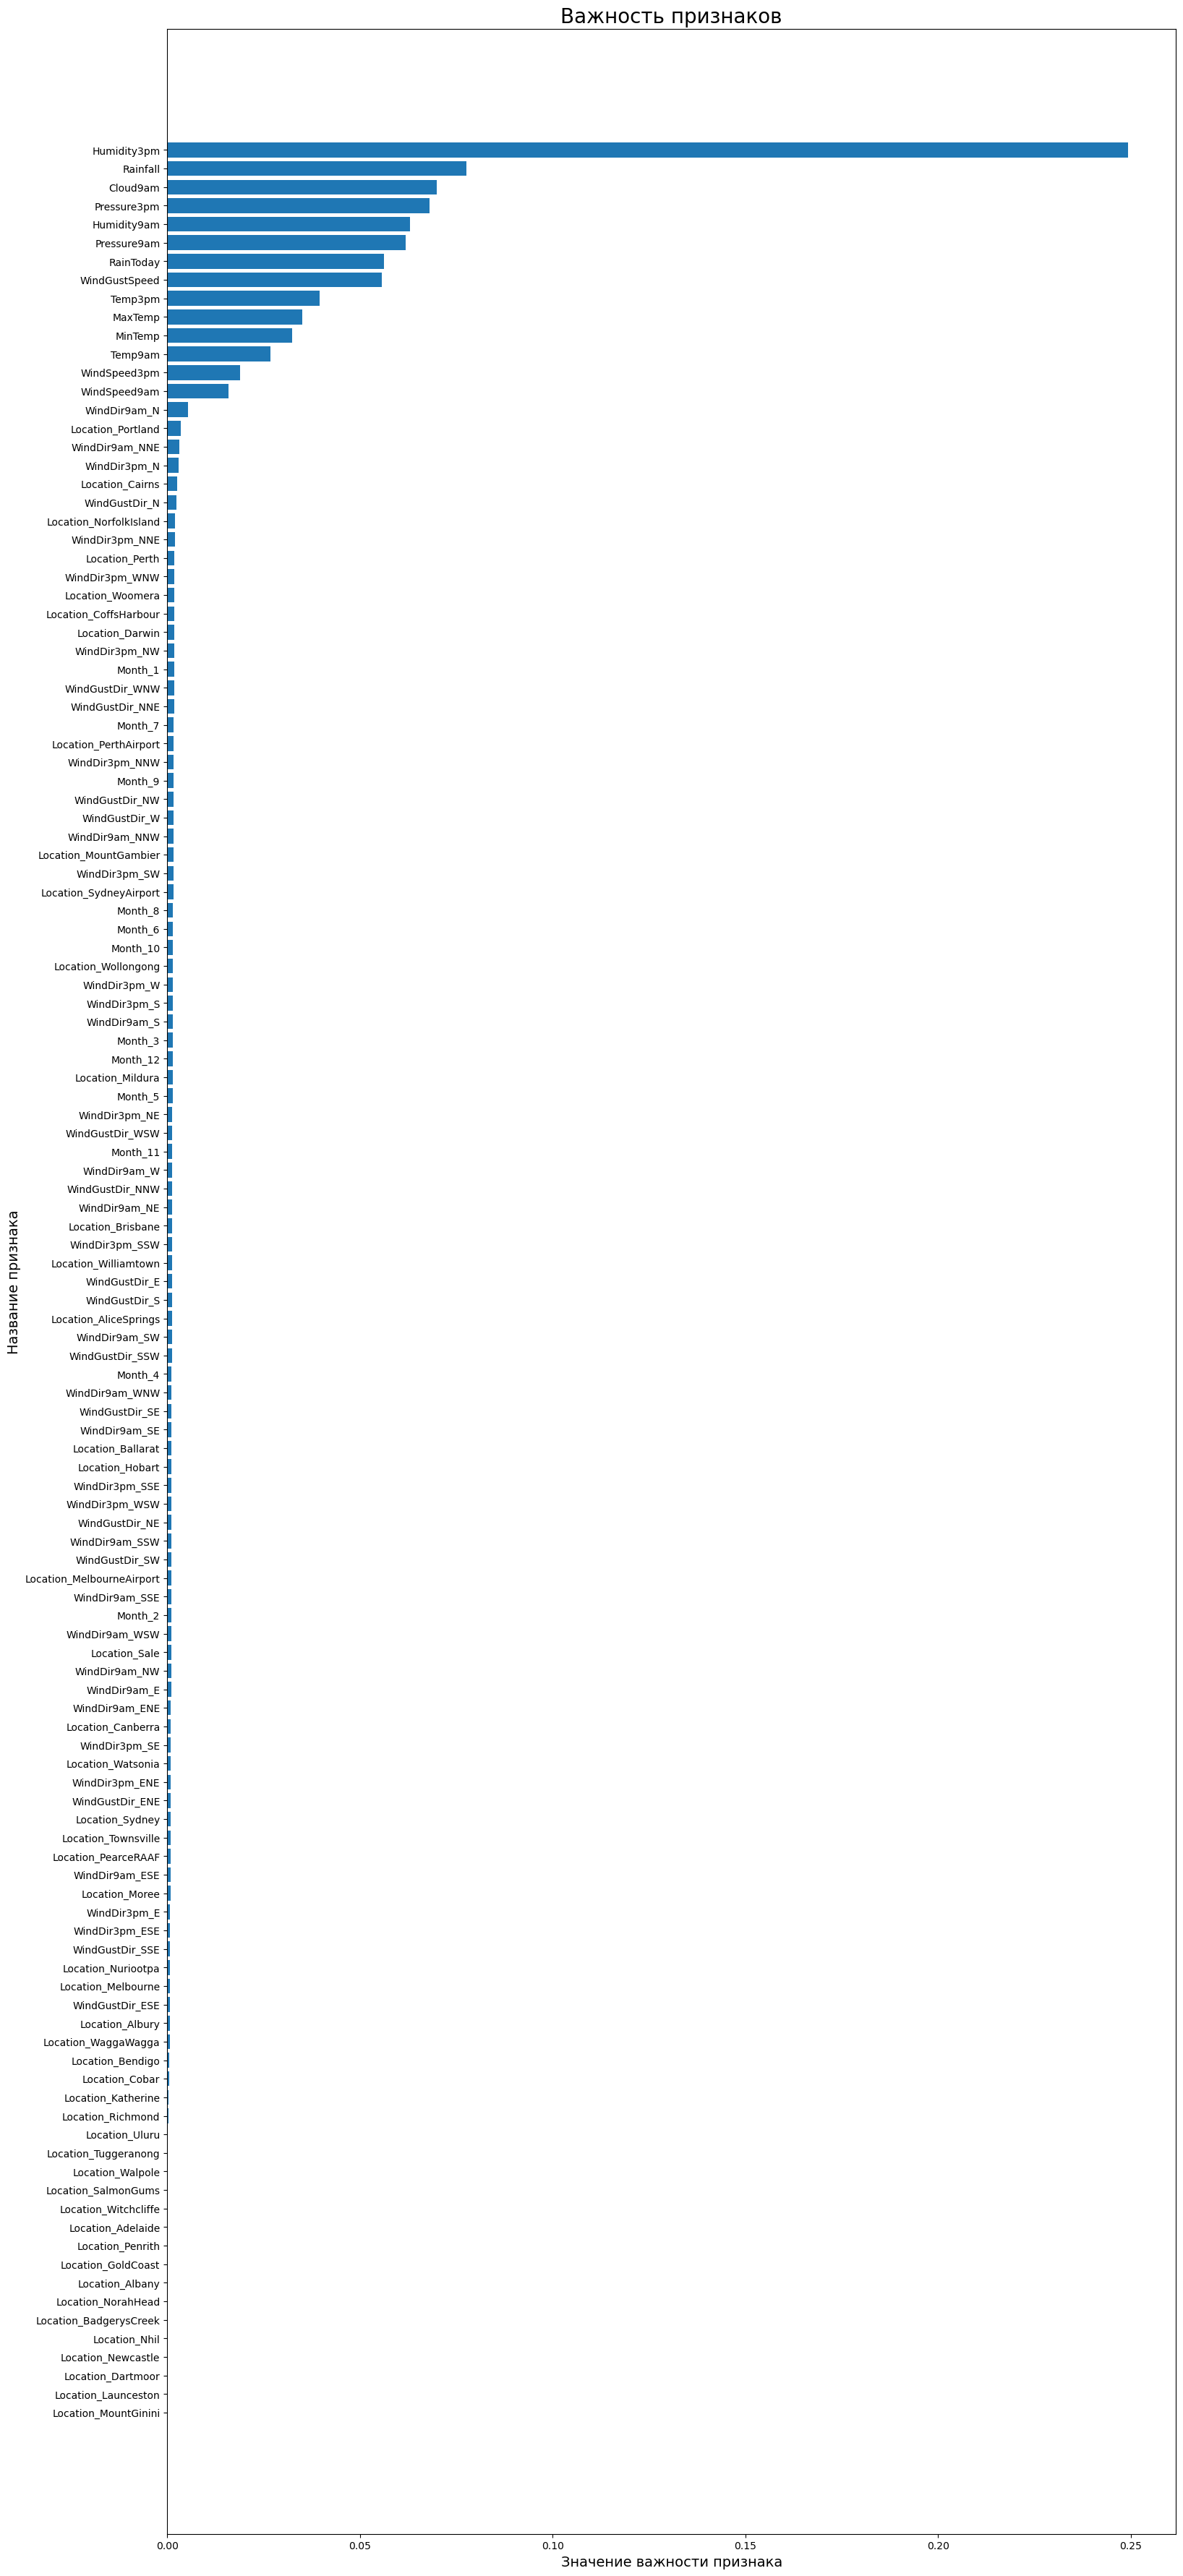

In [25]:
# Визулизируем важность признаков:
fig = plt.figure(figsize=(18,45))

plt.barh(fi_sorted['features'], fi_sorted['feature_importance']);
plt.title('Важность признаков', fontsize=20);
plt.xlabel('Значение важности признака', fontsize=14);
plt.ylabel('Название признака', fontsize=14);